In [ ]:
import os
import zipfile
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

dataset_path = '/kaggle/input/the-oxfordiiit-pet-dataset/images'
output_path = '/kaggle/working/dataset'

if not os.path.exists(dataset_path):
    archive_path = '/kaggle/input/the-oxfordiiit-pet-dataset/images.zip'
    with zipfile.ZipFile(archive_path, 'r') as zip_ref:
        zip_ref.extractall('/kaggle/working/images')
    print("Dataset extracted successfully.")
else:
    print("Dataset already exists.")

def get_class(string):
    for i, ch in enumerate(string):
        if ch.isdigit():
            return string[:i-1]
    return None

images_dir = '/kaggle/working/images' if not os.path.exists(dataset_path) else dataset_path
images = os.listdir(images_dir)

classes = list(set([get_class(img) for img in images if get_class(img) is not None]))

os.makedirs(os.path.join(output_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'val'), exist_ok=True)

val_size = 0.2  
for cl in classes:
    os.makedirs(os.path.join(output_path, 'train', cl), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'val', cl), exist_ok=True)

for image in images:
    cur_class = get_class(image)
    if cur_class is None:
        continue
    src_path = os.path.join(images_dir, image)
    if np.random.random() < 1 - val_size:
        dst_path = os.path.join(output_path, 'train', cur_class, image)
    else:
        dst_path = os.path.join(output_path, 'val', cur_class, image)
    shutil.copy(src_path, dst_path)

print("Data split into train and val folders.")

transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Dataset already exists.
Data split into train and val folders.


In [27]:
# Создание датасетов
train_dataset = datasets.ImageFolder(os.path.join(output_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(output_path, 'val'), transform=transform)

# Размеры датасетов
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Создание DataLoader'ов
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# 4. Настройка модели
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Замена последнего слоя для задачи классификации
num_classes = len(classes)
model.classifier[6] = nn.Linear(4096, num_classes)

# Определение устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Train dataset size: 7316
Validation dataset size: 3653


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
        
        evaluate_model(model, val_loader)

def evaluate_model(model, val_loader):
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 1.3877
Validation Accuracy: 84.70%
Epoch [2/10], Loss: 0.5059
Validation Accuracy: 92.93%
Epoch [3/10], Loss: 0.2695
Validation Accuracy: 94.74%
Epoch [4/10], Loss: 0.1802
Validation Accuracy: 97.83%
Epoch [5/10], Loss: 0.1263
Validation Accuracy: 94.08%
Epoch [6/10], Loss: 0.1189
Validation Accuracy: 98.11%
Epoch [7/10], Loss: 0.0962
Validation Accuracy: 98.88%
Epoch [8/10], Loss: 0.0681
Validation Accuracy: 98.60%
Epoch [9/10], Loss: 0.0615
Validation Accuracy: 98.46%
Epoch [10/10], Loss: 0.0702
Validation Accuracy: 99.23%


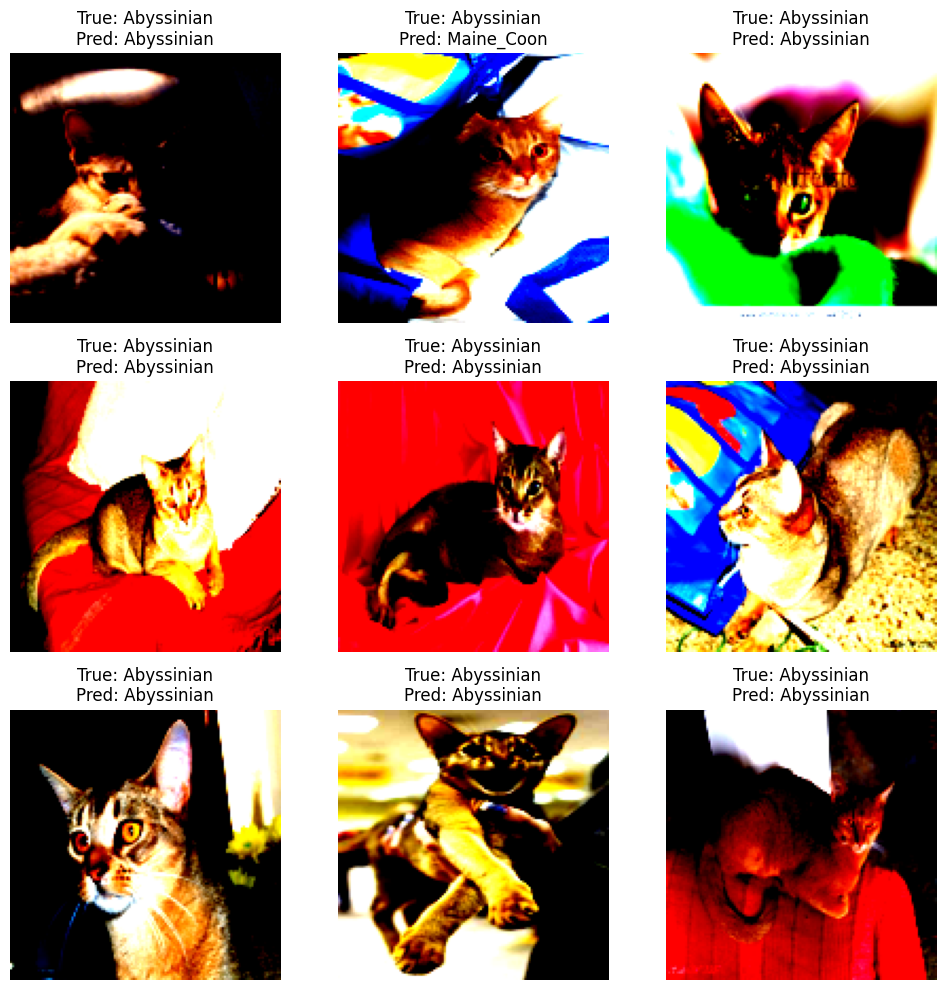

In [ ]:
def visualize_results(model, val_loader):
    model.eval()
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    
    dataiter = iter(val_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    for i in range(9):
        ax = axes[i]
        ax.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
        ax.set_title(f"True: {val_dataset.classes[labels[i]]}\nPred: {val_dataset.classes[predicted[i]]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_results(model, val_loader)

## GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1),  
            nn.Flatten(), 
            nn.Linear(256, 1),  
            nn.Sigmoid() 
        )

    def forward(self, input):
        return self.main(input)

netG = Generator().to(device)
netD = Discriminator().to(device)

optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

for epoch in range(20):
    for i, data in enumerate(train_loader):
        netD.zero_grad()
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_images).view(-1)
        loss_real = criterion(output, labels)
        loss_real.backward()

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(fake_label)

        output = netD(fake_images.detach()).view(-1)
        loss_fake = criterion(output, labels)
        loss_fake.backward()

        optimizerD.step()

        netG.zero_grad()
        labels.fill_(real_label)  
        output = netD(fake_images).view(-1)
        loss_G = criterion(output, labels)
        loss_G.backward()

        optimizerG.step()

        if i % 50 == 0:
            print(f"[{epoch}/20] [{i}/{len(train_loader)}] Loss_D: {loss_real + loss_fake}, Loss_G: {loss_G}")

[0/20] [0/114] Loss_D: 1.4295005798339844, Loss_G: 0.8805082440376282
[0/20] [50/114] Loss_D: 1.042551040649414, Loss_G: 0.9281526803970337
[0/20] [100/114] Loss_D: 1.1089369058609009, Loss_G: 1.000257134437561
[1/20] [0/114] Loss_D: 1.0921919345855713, Loss_G: 0.9303560256958008
[1/20] [50/114] Loss_D: 1.0054919719696045, Loss_G: 1.0453009605407715
[1/20] [100/114] Loss_D: 0.7662385106086731, Loss_G: 1.2133418321609497
[2/20] [0/114] Loss_D: 0.7023056745529175, Loss_G: 1.369473934173584
[2/20] [50/114] Loss_D: 0.6047267913818359, Loss_G: 1.4650142192840576
[2/20] [100/114] Loss_D: 0.6241918802261353, Loss_G: 1.4463374614715576
[3/20] [0/114] Loss_D: 0.6128928661346436, Loss_G: 1.4486722946166992
[3/20] [50/114] Loss_D: 0.5139180421829224, Loss_G: 1.59781813621521
[3/20] [100/114] Loss_D: 0.41433024406433105, Loss_G: 1.7752540111541748
[4/20] [0/114] Loss_D: 0.43407511711120605, Loss_G: 1.746622085571289
[4/20] [50/114] Loss_D: 0.31119200587272644, Loss_G: 2.039982557296753
[4/20] [100

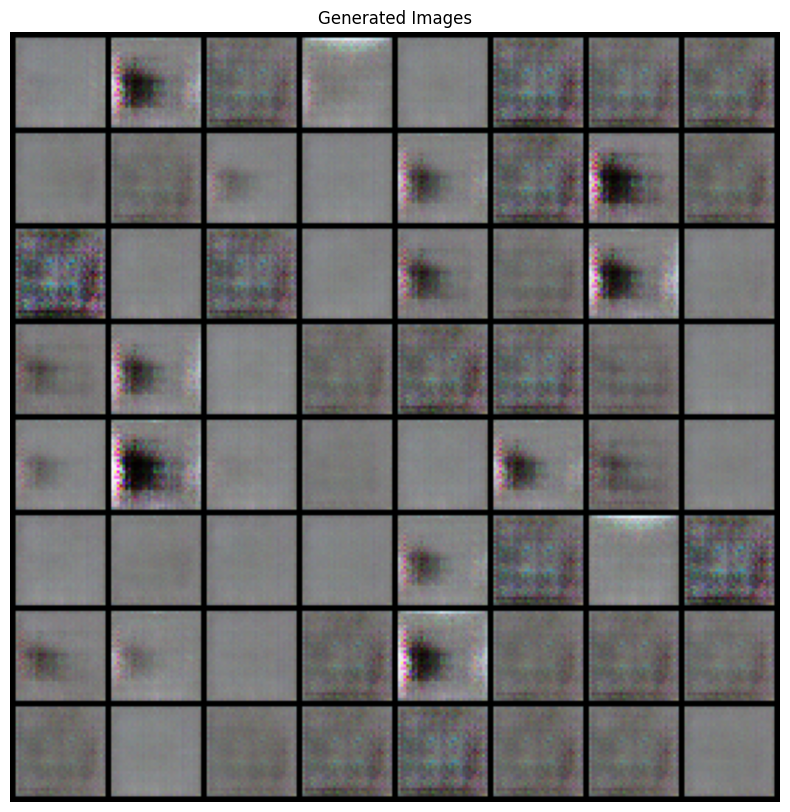

In [ ]:
import torchvision.utils as vutils

def visualize_generated_images(netG, fixed_noise, device):
    netG.eval()  
    with torch.no_grad():
        fake_images = netG(fixed_noise).detach().cpu()  
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Generated Images")
    grid = vutils.make_grid(fake_images, padding=2, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))  
    plt.show()

visualize_generated_images(netG, fixed_noise, device)